# Visualization of the computational experiment

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('..'))
from constants.constants import EXPERIMENTS_FOLDER

plt.rcParams['figure.dpi'] = 300

### Fetching the results file

In [2]:
results_file = os.path.join(EXPERIMENTS_FOLDER, 'results', 'results_0_3_constraints.csv')

In [3]:
column_names = [
    'NumProducts',
    'Run',
    'Approach',
    'Consider_Constraints',
    'Time',
    'OptValue',
    'C',
    'ClingoStats_Constraints',
    'ClingoStats_Complexity',
    'ClingoStats_Vars',
    'ClingoStats_Atoms',
    'ClingoStats_Bodies',
    'ClingoStats_Rules',
    'ClingoStats_Choices',
    'ClingoStats_Conflicts',
    'ClingoStats_Restarts',
    'ClingoStats_Models',
    'Variables',
    'Constraints',
    'Order',
    'Timeout'
]

In [4]:
df = pd.read_csv(results_file, names=column_names)
df = df.sort_values(by=['NumProducts', 'Run', 'Approach', 'Consider_Constraints'])
df[['NumProducts', 'Run', 'Approach', 'Consider_Constraints', 'Time', 'OptValue', 'C', 'Timeout']]

,NumProducts,Run,Approach,Consider_Constraints,Time,OptValue,C,Timeout
483,6,0,ilp,0,0.300087,NaN,480,False
1061,6,0,ilp,3,0.523708,NaN,480,False
67,6,0,lp_advanced,0,0.061758,480.0,480,False
627,6,0,lp_advanced,3,0.065314,480.0,480,False
3,6,0,lp_normal,0,0.088970,480.0,480,False
...,...,...,...,...,...,...,...,...
1056,71,1,tsp,3,7.309955,NaN,4275,False
476,71,2,tsp,0,7.370952,NaN,3810,False
1058,71,2,tsp,3,7.565383,NaN,4275,False
477,71,3,tsp,0,7.725525,NaN,3810,False


### Get Approaches, Runs, NumProducts and Consider_Constraints_Options

In [5]:
approaches = df['Approach'].drop_duplicates().to_list()
approaches

['ilp', 'lp_advanced', 'lp_normal', 'tsp']

In [6]:
runs = df['Run'].drop_duplicates().to_list()
runs

[0, 1, 2, 3]

In [7]:
numProducts = df['NumProducts'].drop_duplicates().to_list()
numProducts

[6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71]

In [8]:
consider_constraints_options = df['Consider_Constraints'].drop_duplicates().to_list()
consider_constraints_options

[0, 3]

### Check data sanity

In [9]:
for numProduct in numProducts:
    df_temp_numProduct = df[df['NumProducts'] == numProduct]
    for run in runs:
        df_temp_run = df_temp_numProduct[df_temp_numProduct['Run'] == run]
        for consider_constraints in consider_constraints_options:
            df_temp_constraints = df_temp_run[df_temp_run['Consider_Constraints'] == consider_constraints]
            df_temp_constraints_woT = df_temp_constraints[df_temp_constraints['Timeout'] == False]
            if len(df_temp_constraints_woT['C'].drop_duplicates().to_list()) > 1:
                print('ERROR')
                print(f'numProduct: {numProduct} run: {run} consider_constraints: {consider_constraints}')
                print(df_temp_constraints_woT[['Approach', 'C']])
                print()

ERROR
numProduct: 35 run: 0 consider_constraints: 3
        Approach     C
742  lp_advanced  2775
914          tsp  2790

ERROR
numProduct: 36 run: 0 consider_constraints: 3
        Approach     C
746  lp_advanced  2790
917          tsp  2805



In [10]:
for numProduct in numProducts:
    df_temp_numProduct = df[df['NumProducts'] == numProduct]
    for run in runs:
        df_temp_run = df_temp_numProduct[df_temp_numProduct['Run'] == run]
        for consider_constraints in consider_constraints_options:
            df_temp_constraints = df_temp_run[df_temp_run['Consider_Constraints'] == consider_constraints]
            df_temp_constraints_woT = df_temp_constraints[df_temp_constraints['Timeout'] == False]
            if len(df_temp_constraints_woT['Order'].drop_duplicates().to_list()) > 1:
                print('ERROR')
                print(f'numProduct: {numProduct} run: {run} consider_constraints: {consider_constraints}')
                print(df_temp_constraints_woT[['Approach', 'Order']])
                print()

ERROR
numProduct: 6 run: 0 consider_constraints: 0
        Approach                                Order
483          ilp  21968 19046 18920 23155 18333 23358
67   lp_advanced  21968 18920 19046 23358 18333 23155
3      lp_normal  18920 19046 21968 18333 23358 23155
219          tsp  21968 18920 19046 23358 18333 23155

ERROR
numProduct: 6 run: 0 consider_constraints: 3
         Approach                                Order
1061          ilp  18920 19046 21968 23155 18333 23358
627   lp_advanced  18920 21968 19046 23155 18333 23358
530     lp_normal  18920 21968 19046 18333 23358 23155
798           tsp  18920 21968 19046 23155 18333 23358

ERROR
numProduct: 6 run: 1 consider_constraints: 0
        Approach                                Order
481          ilp  23546 23071 22180 21845 22250 22249
64   lp_advanced  23546 22180 23071 21845 22249 22250
0      lp_normal  23546 22180 22250 22249 23071 21845
216          tsp  23546 22249 23071 21845 22180 22250

ERROR
numProduct: 6 run: 1 co

### Preprocessing the data for plotting

In [11]:
metrics = {
    'Time': 'Computation time (in sec)',
    'ClingoStats_Constraints': 'Number of constraints (clingo)',
    'ClingoStats_Complexity': 'Degree of complexity (clingo)',
    'ClingoStats_Vars': 'Number of variables (clingo)',
    'ClingoStats_Atoms': 'Number of atoms (clingo)',
    'ClingoStats_Bodies': 'Number of bodies (clingo)',
    'ClingoStats_Rules': 'Number of rules (clingo)',
    'ClingoStats_Choices': 'Number of choices (clingo)',
    'ClingoStats_Conflicts': 'Number of conflicts (clingo)',
    'ClingoStats_Restarts': 'Number of restarts (clingo)',
    'ClingoStats_Models': 'Number of models (clingo)',
    'Variables': 'Number of variables (docplex)',
    'Constraints': 'Number of constraints (docplex)'
}

In [12]:
data = {}
for approach in approaches:
    data[approach] = {}
    df_approach = df[df['Approach'] == approach]

    for consider_constraints in consider_constraints_options:
        data[approach][consider_constraints] = {}
        df_constraints = df_approach[df_approach['Consider_Constraints'] == consider_constraints]
        
        for metric in metrics:
            data[approach][consider_constraints][metric] = {'numProducts': [], 'lbs': [], 'ubs': [], 'means': []}
        
            for numProduct in numProducts:
                df_numProduct = df_constraints[df_constraints['NumProducts'] == numProduct]
                if metric != 'Time':
                    df_numProduct = df_numProduct[df_numProduct['Timeout'] == False]
                
                if not df_numProduct.empty:
                    values = df_numProduct[metric].to_list()
                    lb = min(values)
                    ub = max(values)
                    mean = float(sum(values)) / len(values)
                    if not pd.isna(mean):
                        data[approach][consider_constraints][metric]['lbs'].append(lb)
                        data[approach][consider_constraints][metric]['ubs'].append(ub)
                        data[approach][consider_constraints][metric]['means'].append(mean)
                        data[approach][consider_constraints][metric]['numProducts'].append(numProduct)

## Creating plots

In [15]:
# labels = {
#     0: 'All constraints',
#     1: 'Constr. 1',
#     2: 'Constr. 2',
#     3: 'Constr. 3',
#     4: 'Constr. 4'
# }

labels = {
    'lp_advanced': {
        0: 'ASP w/o constr.', 3: 'ASP with constr.'
    },
    'tsp': {
        0: 'TSP w/o constr.', 3: 'TSP with constr.'
    },
    'ilp': {
        0: 'ILP w/o constr.', 3: 'ILP with constr.'
    }
}

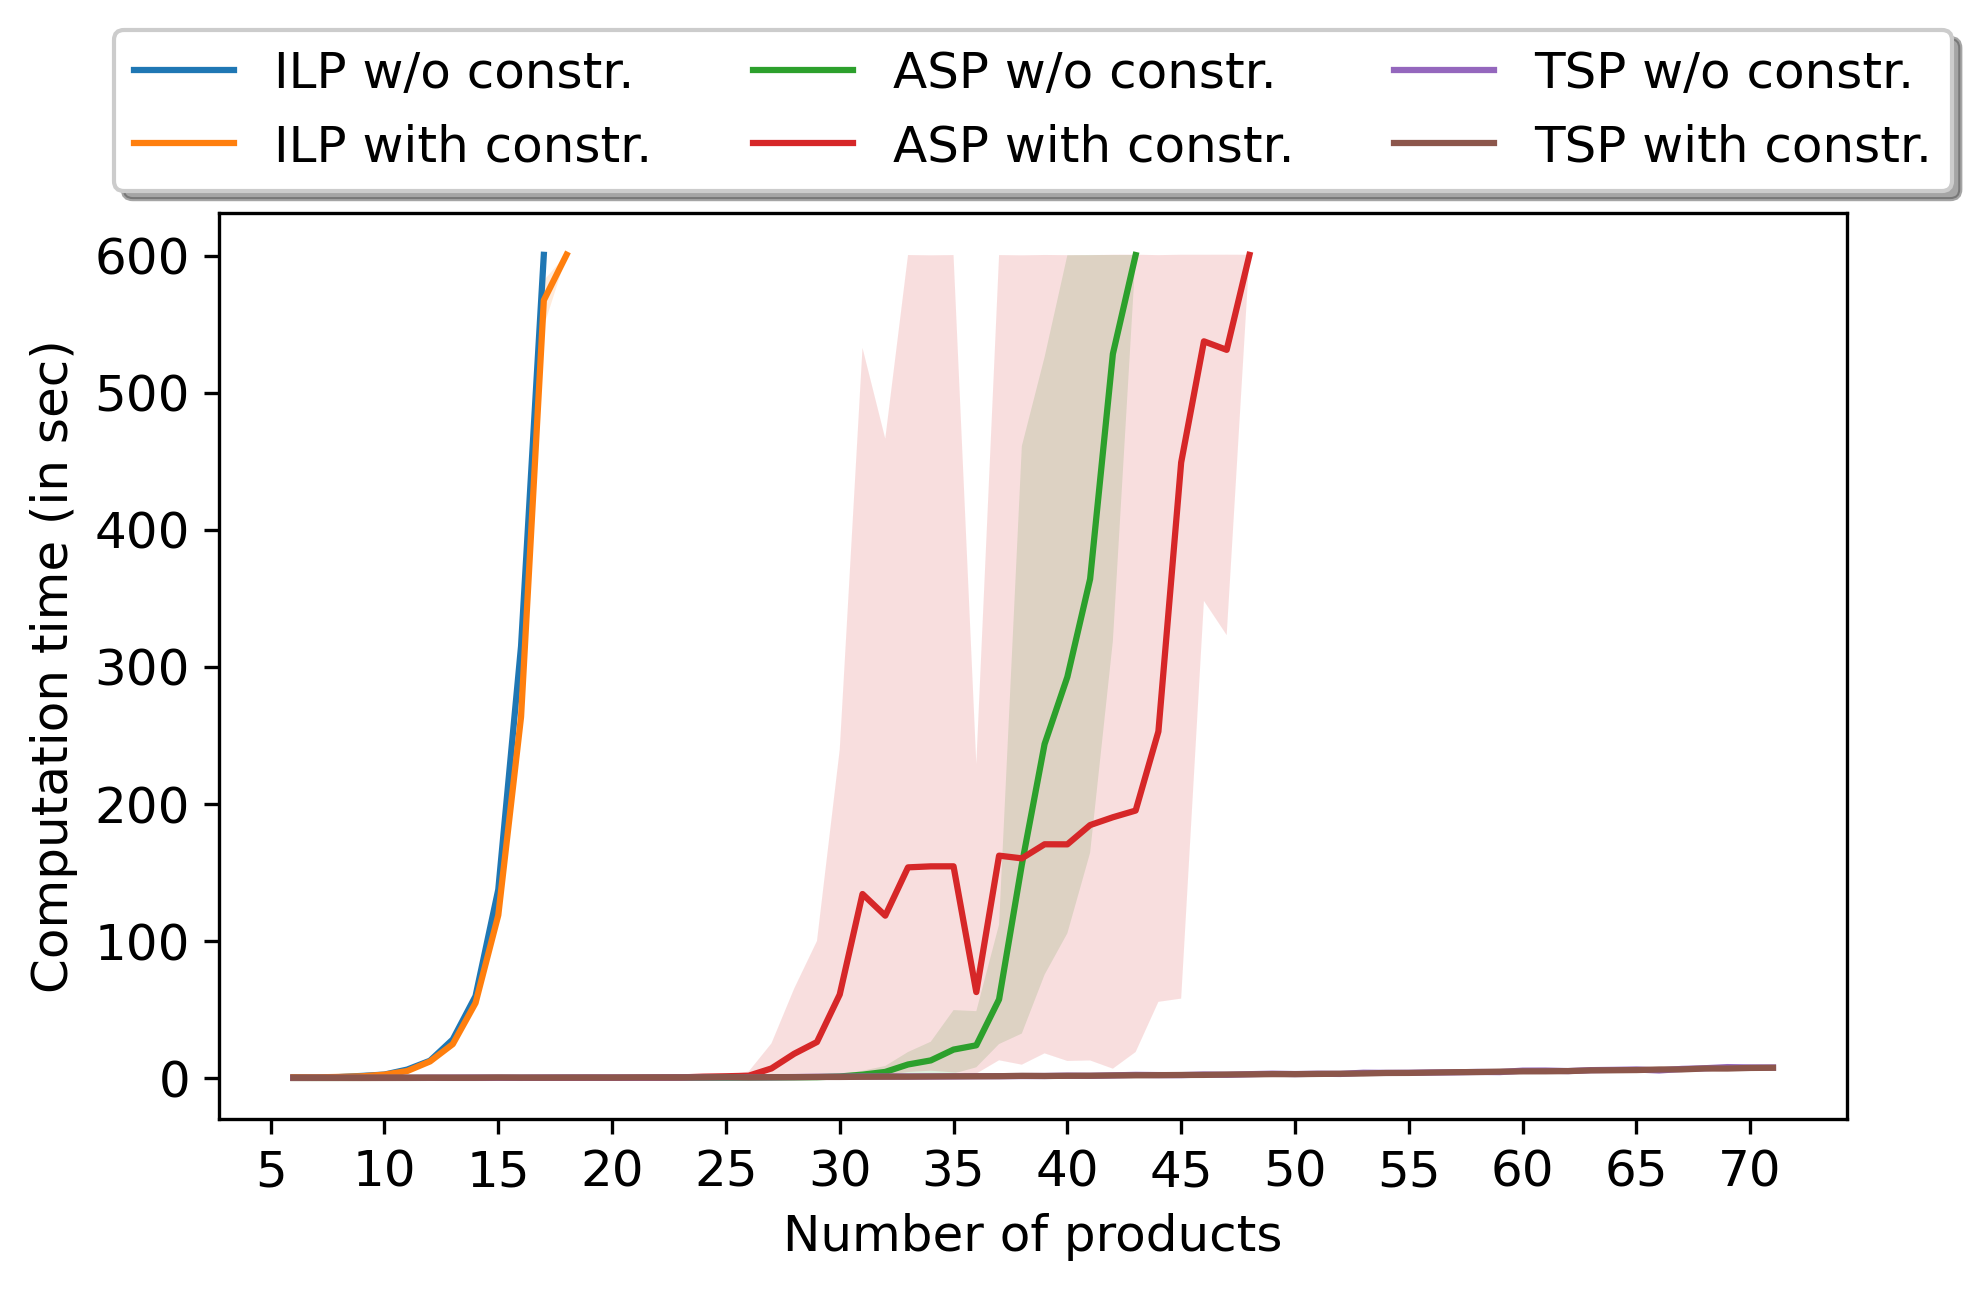

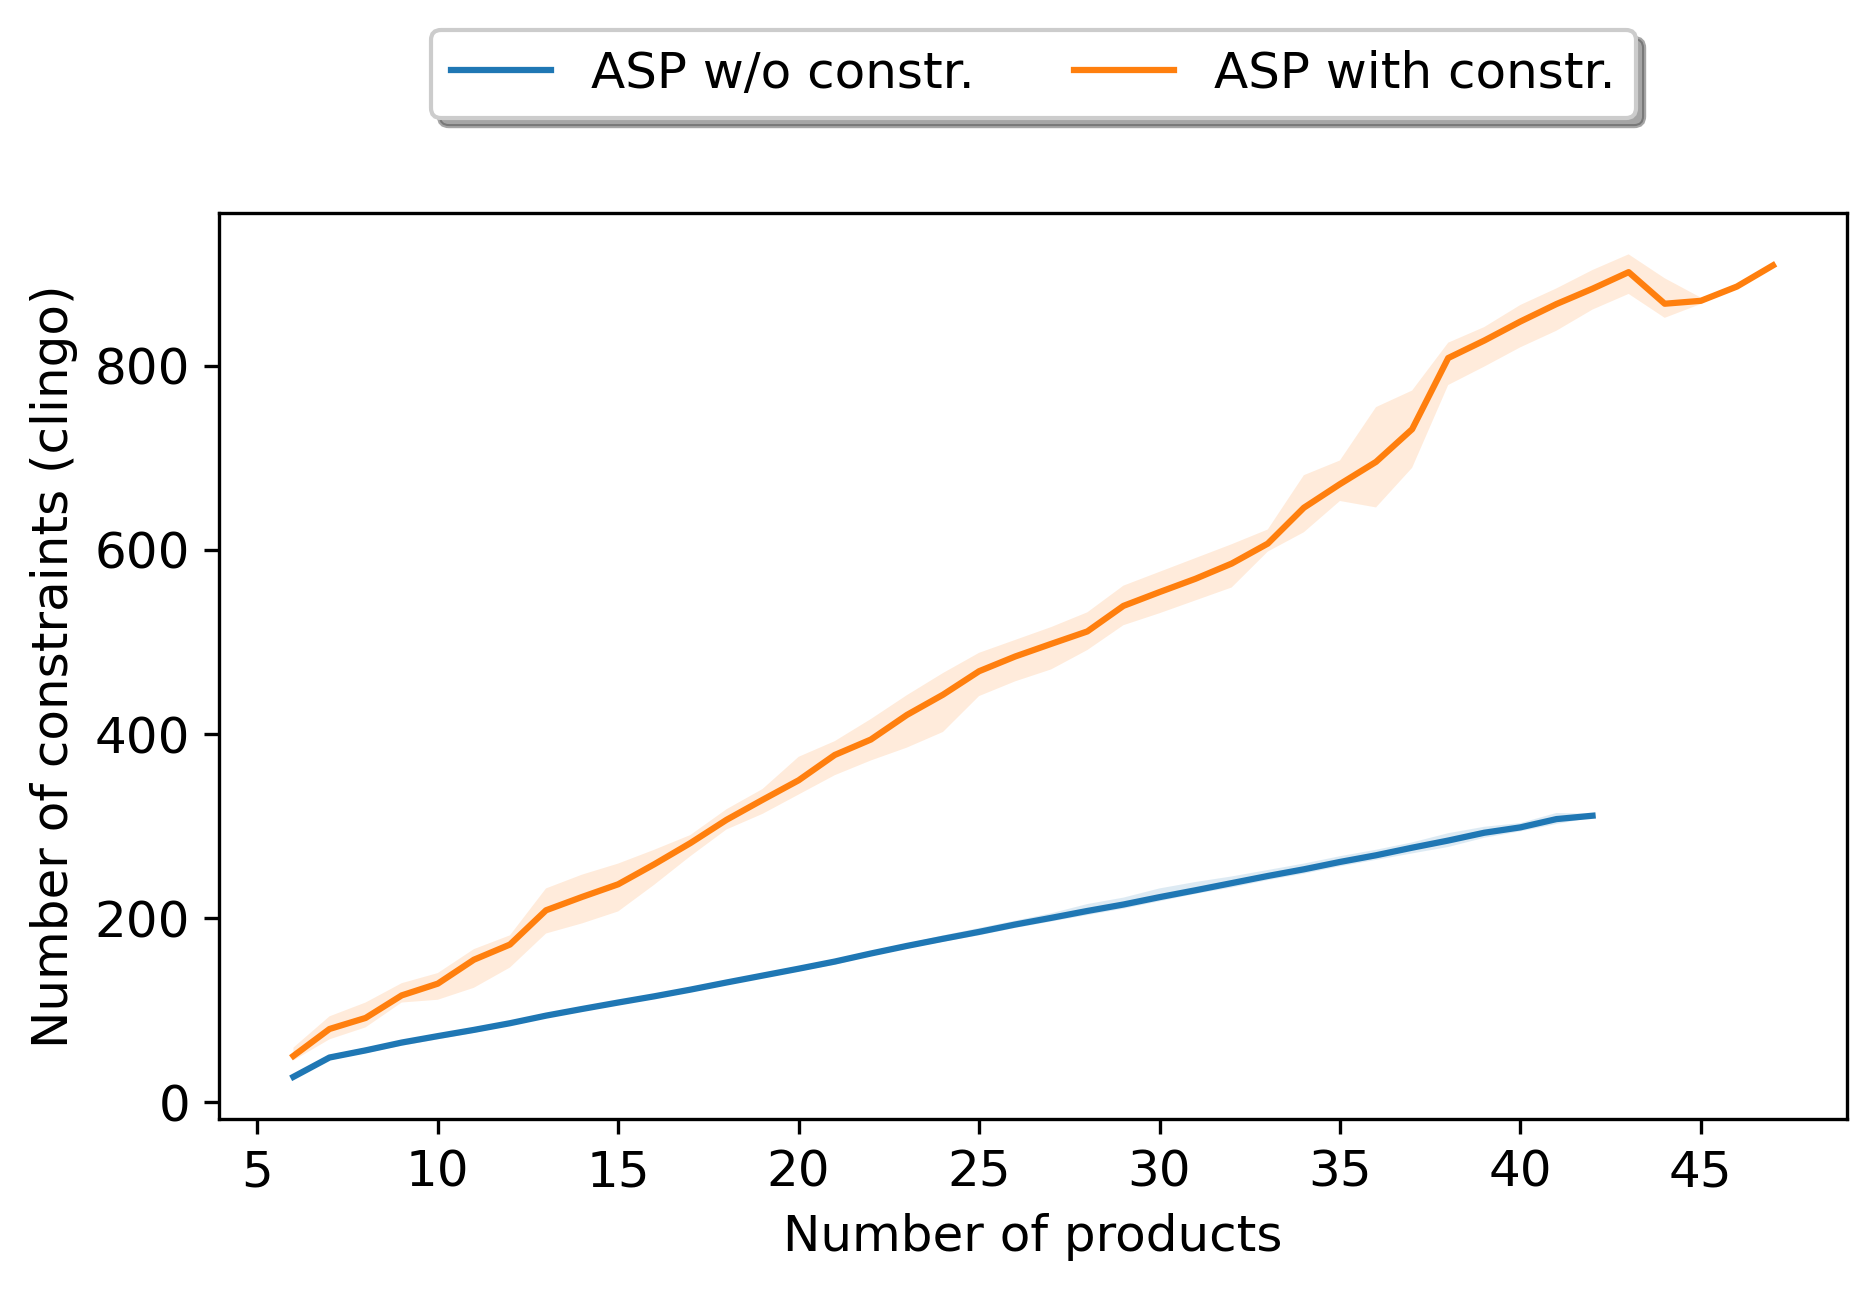

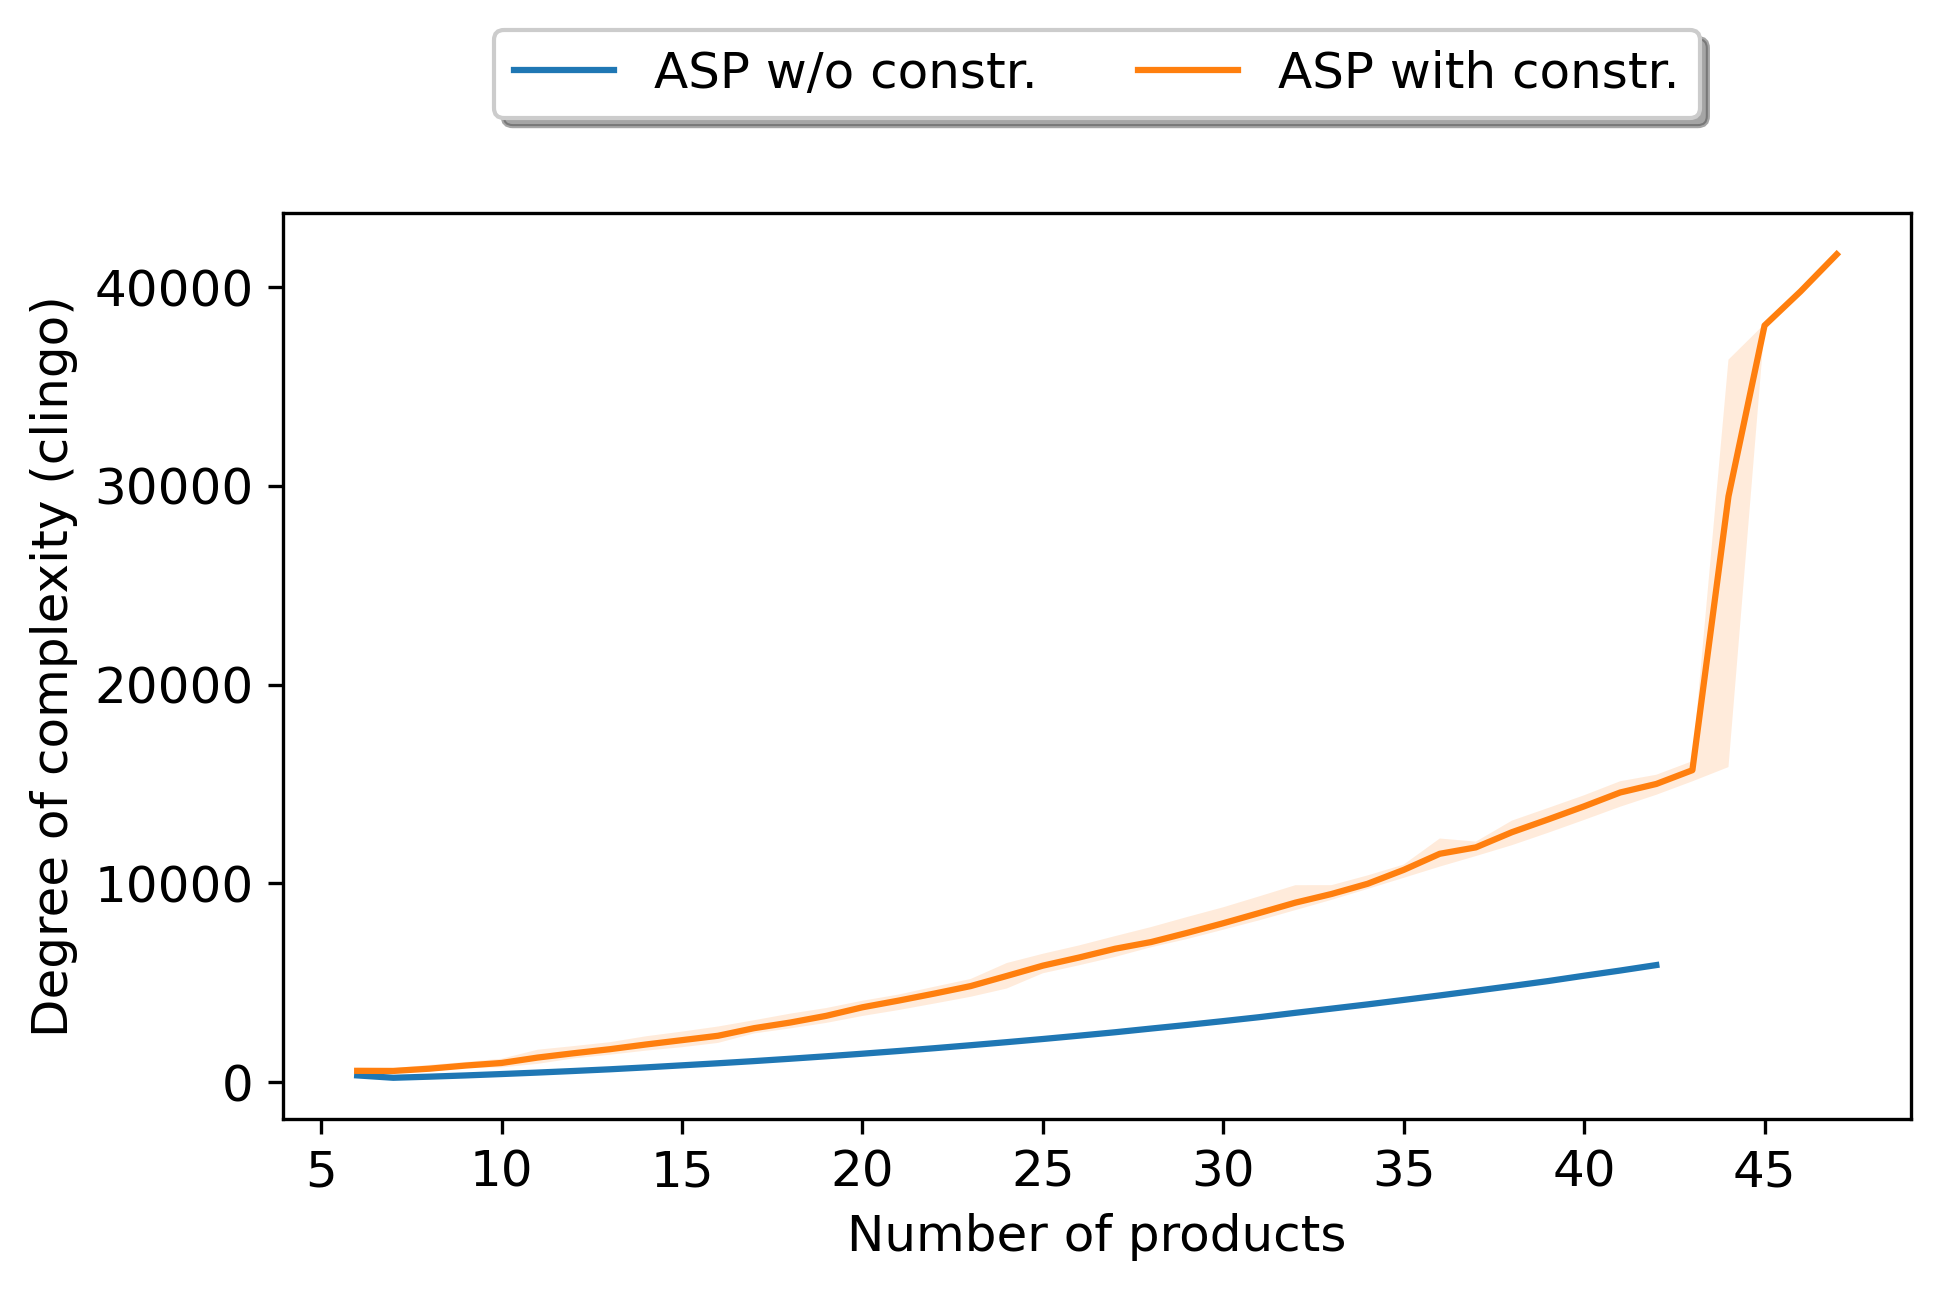

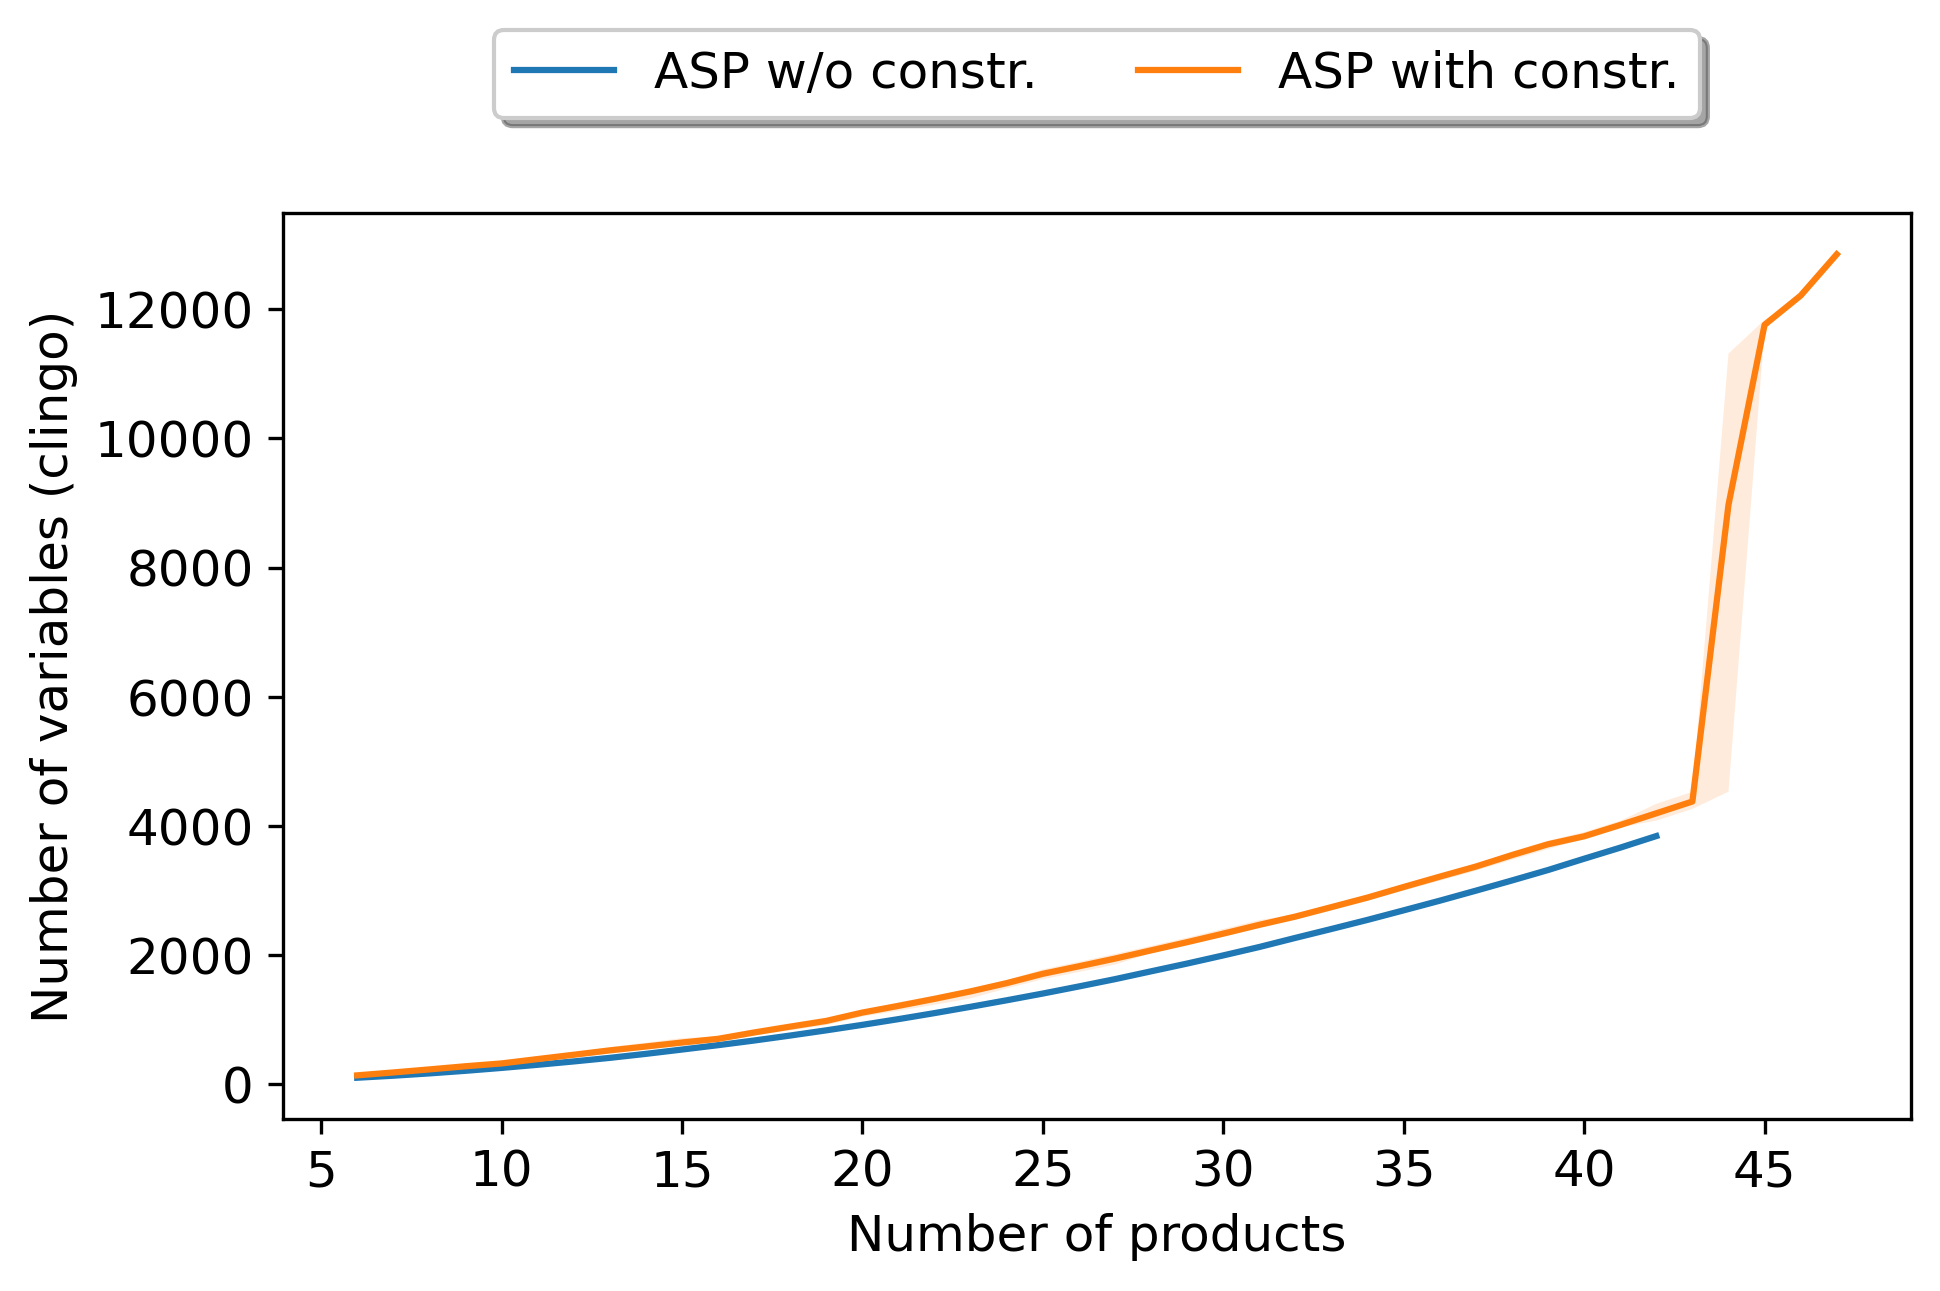

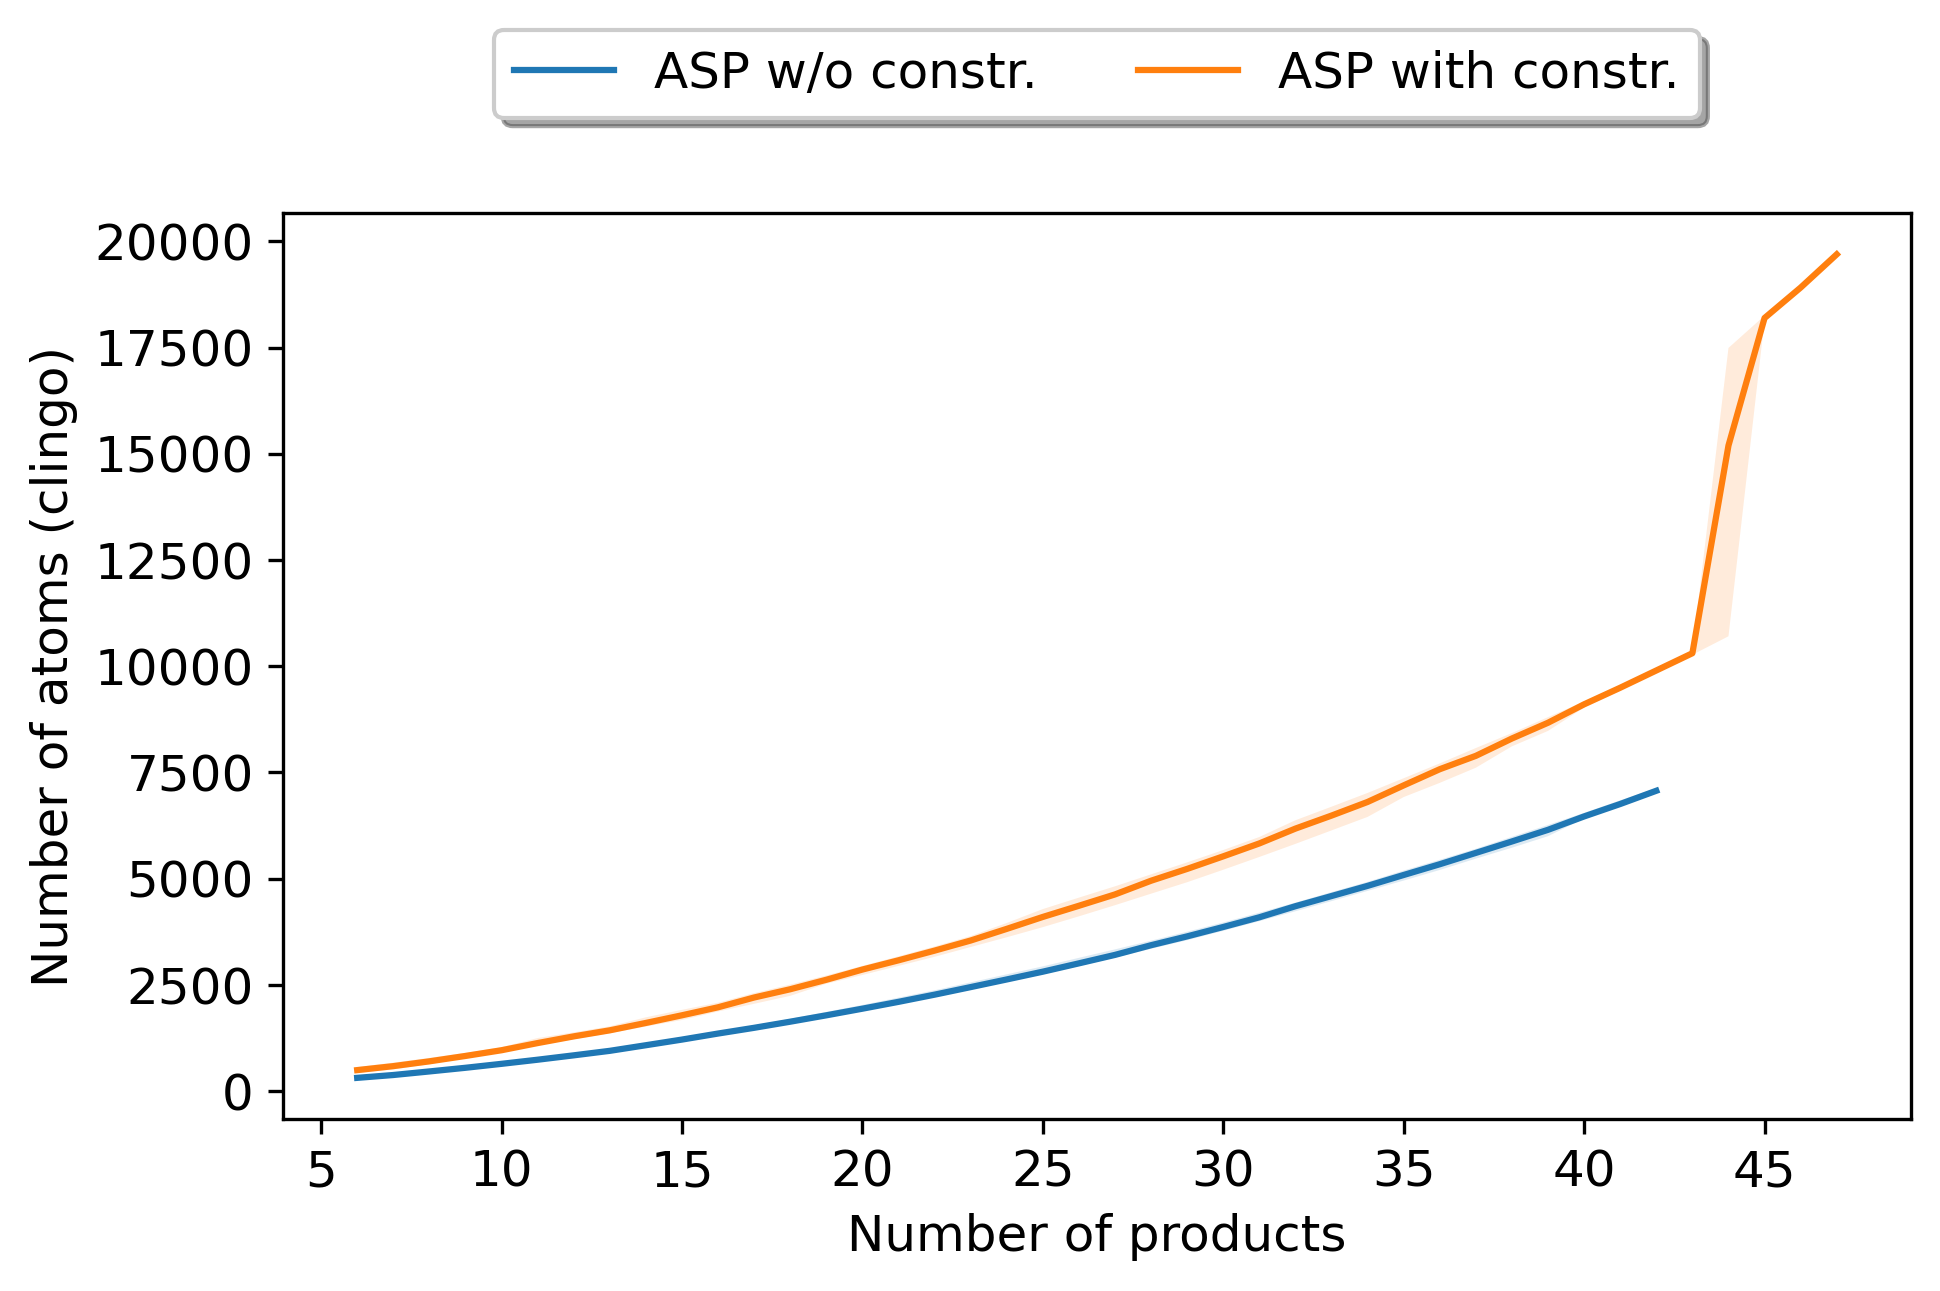

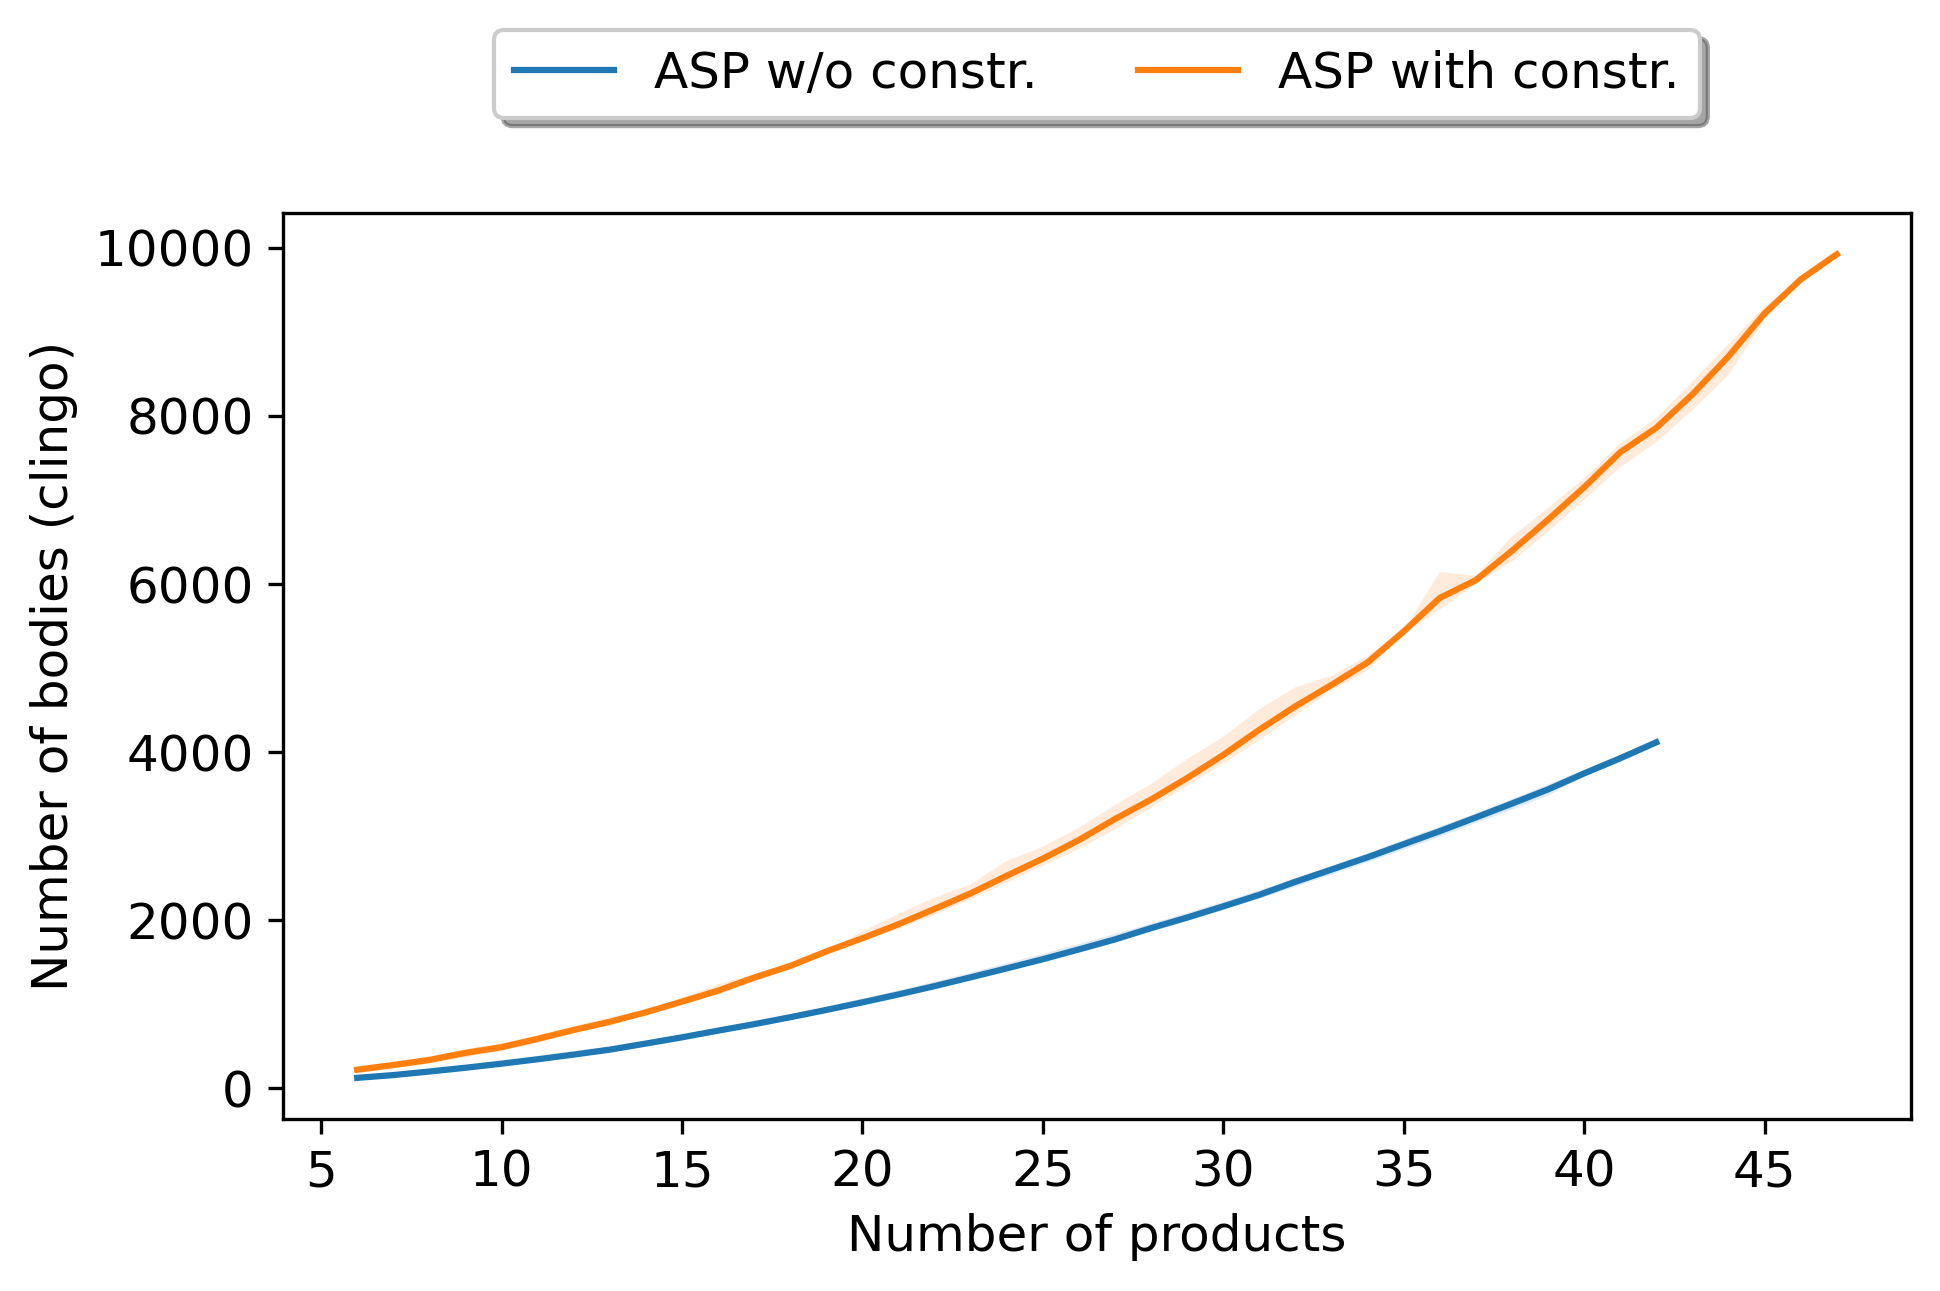

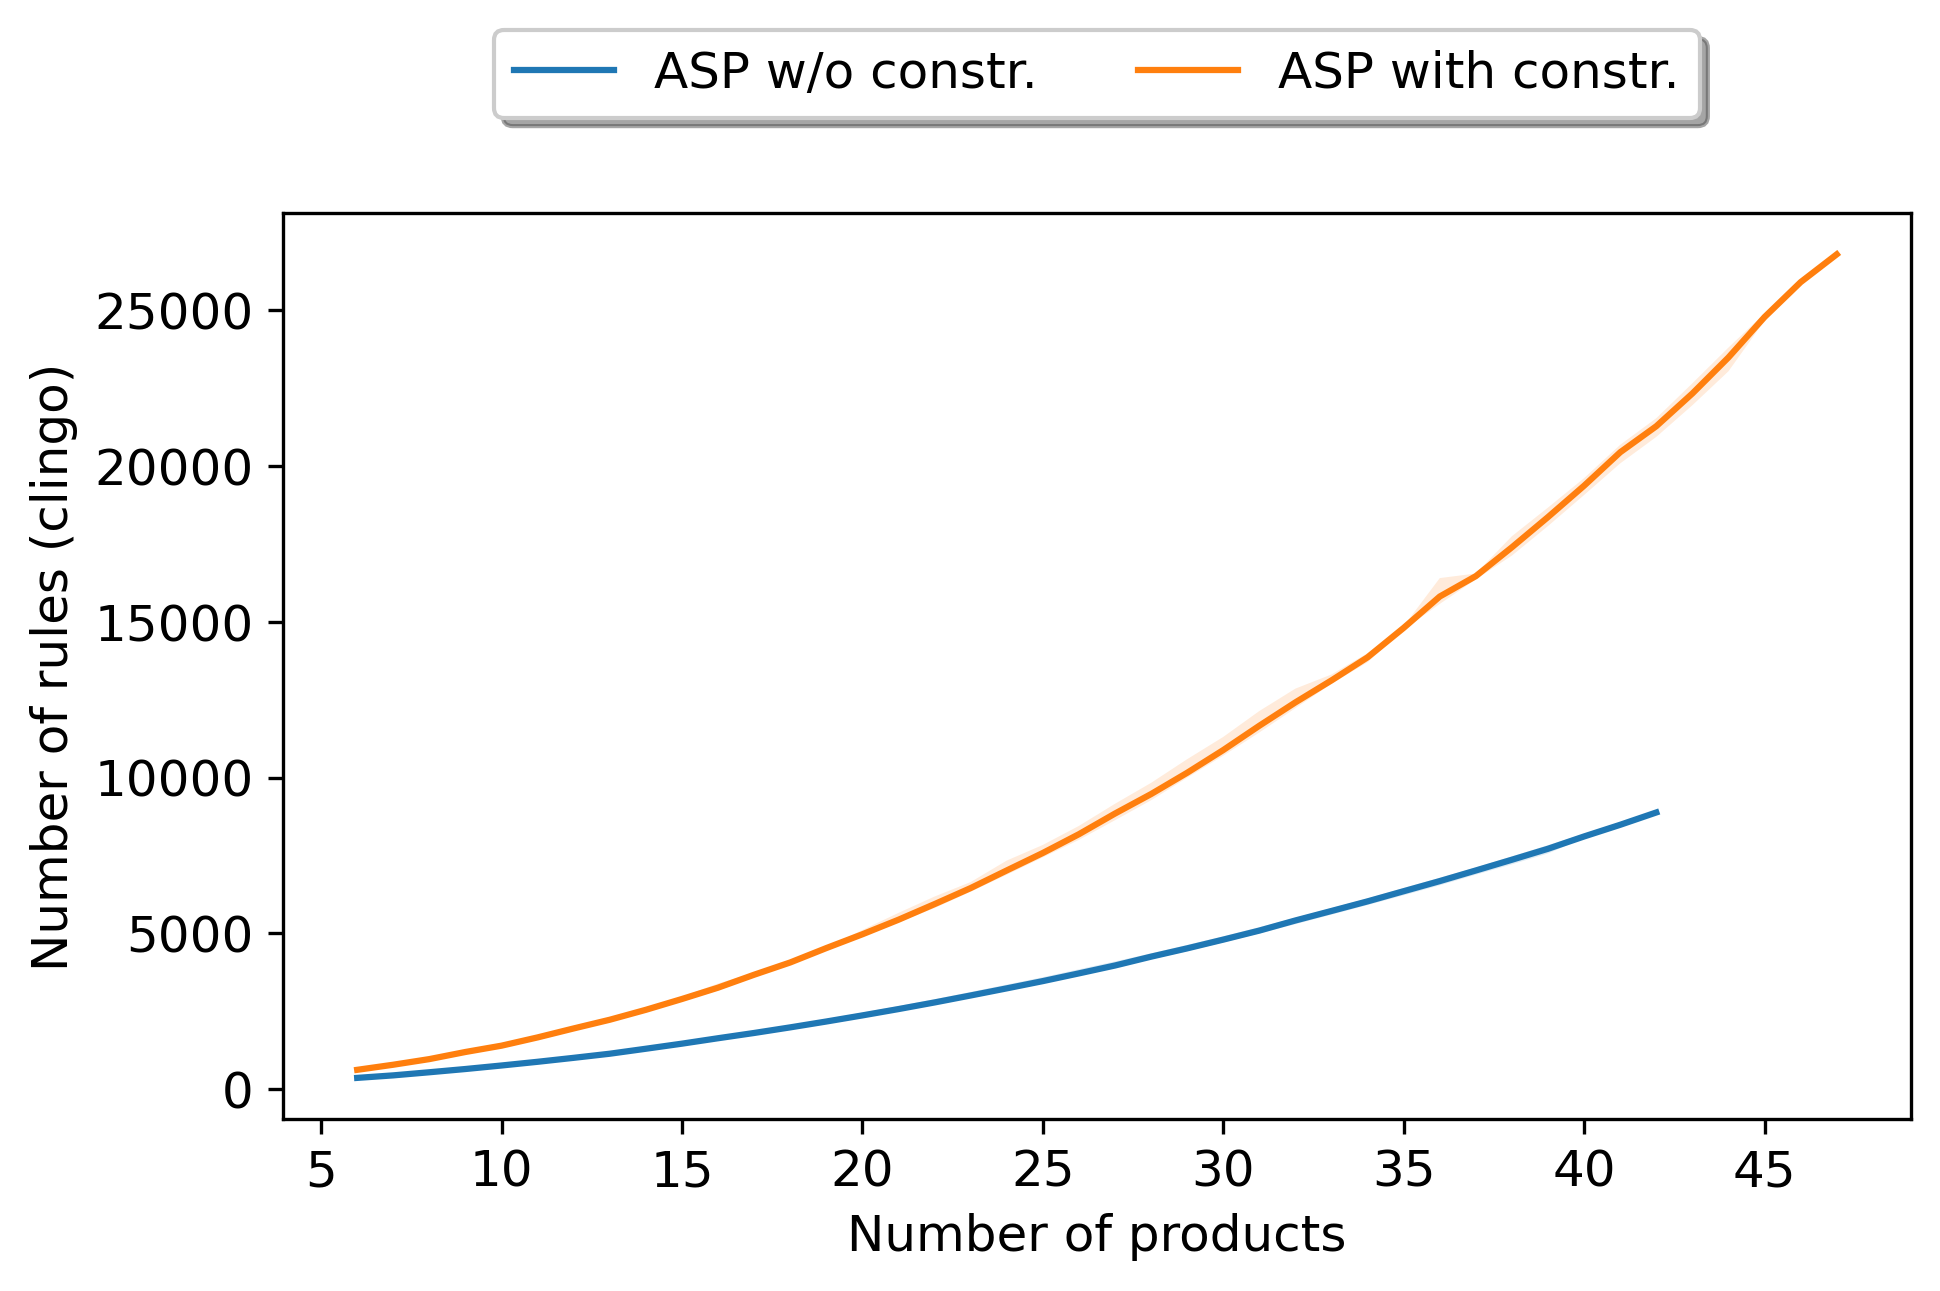

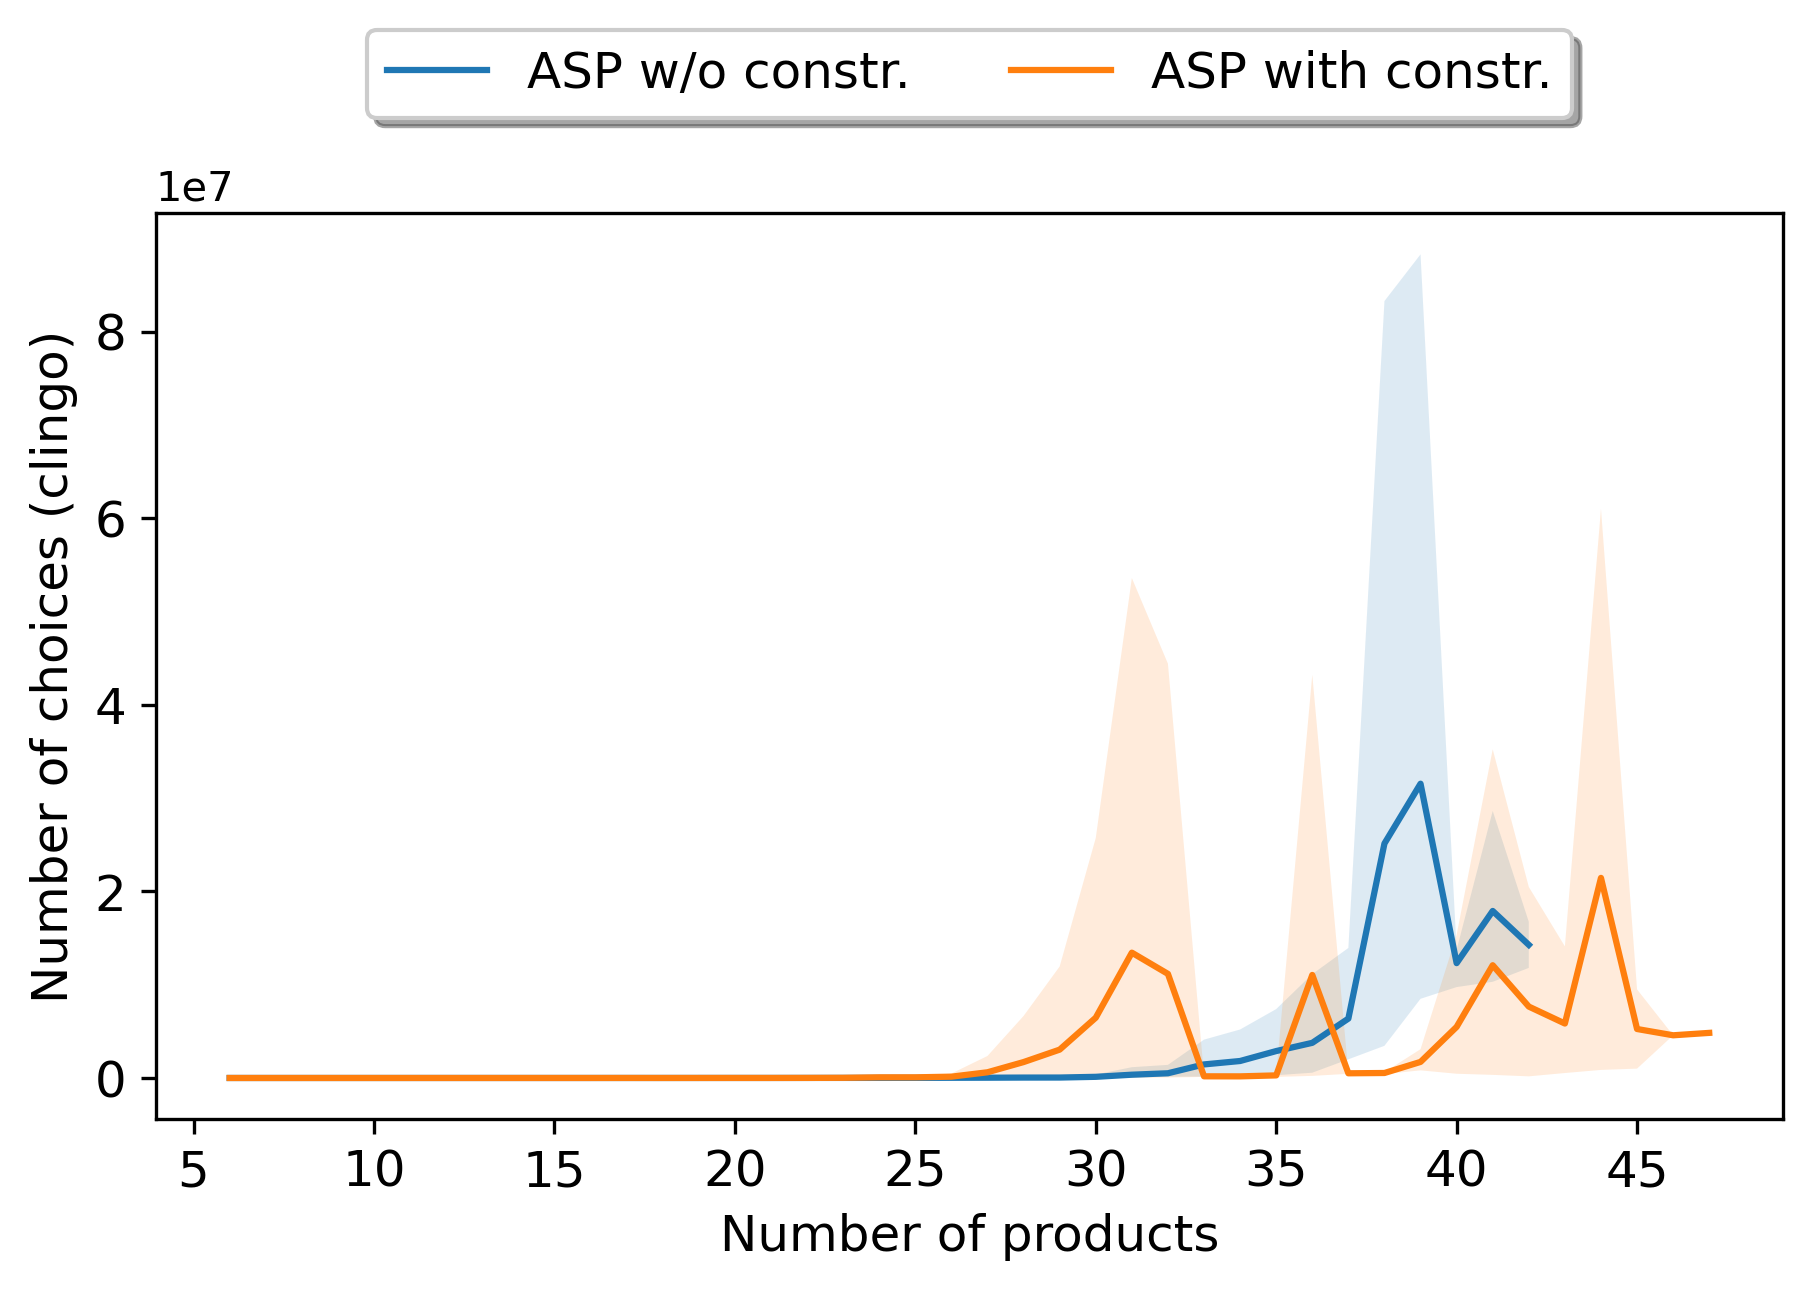

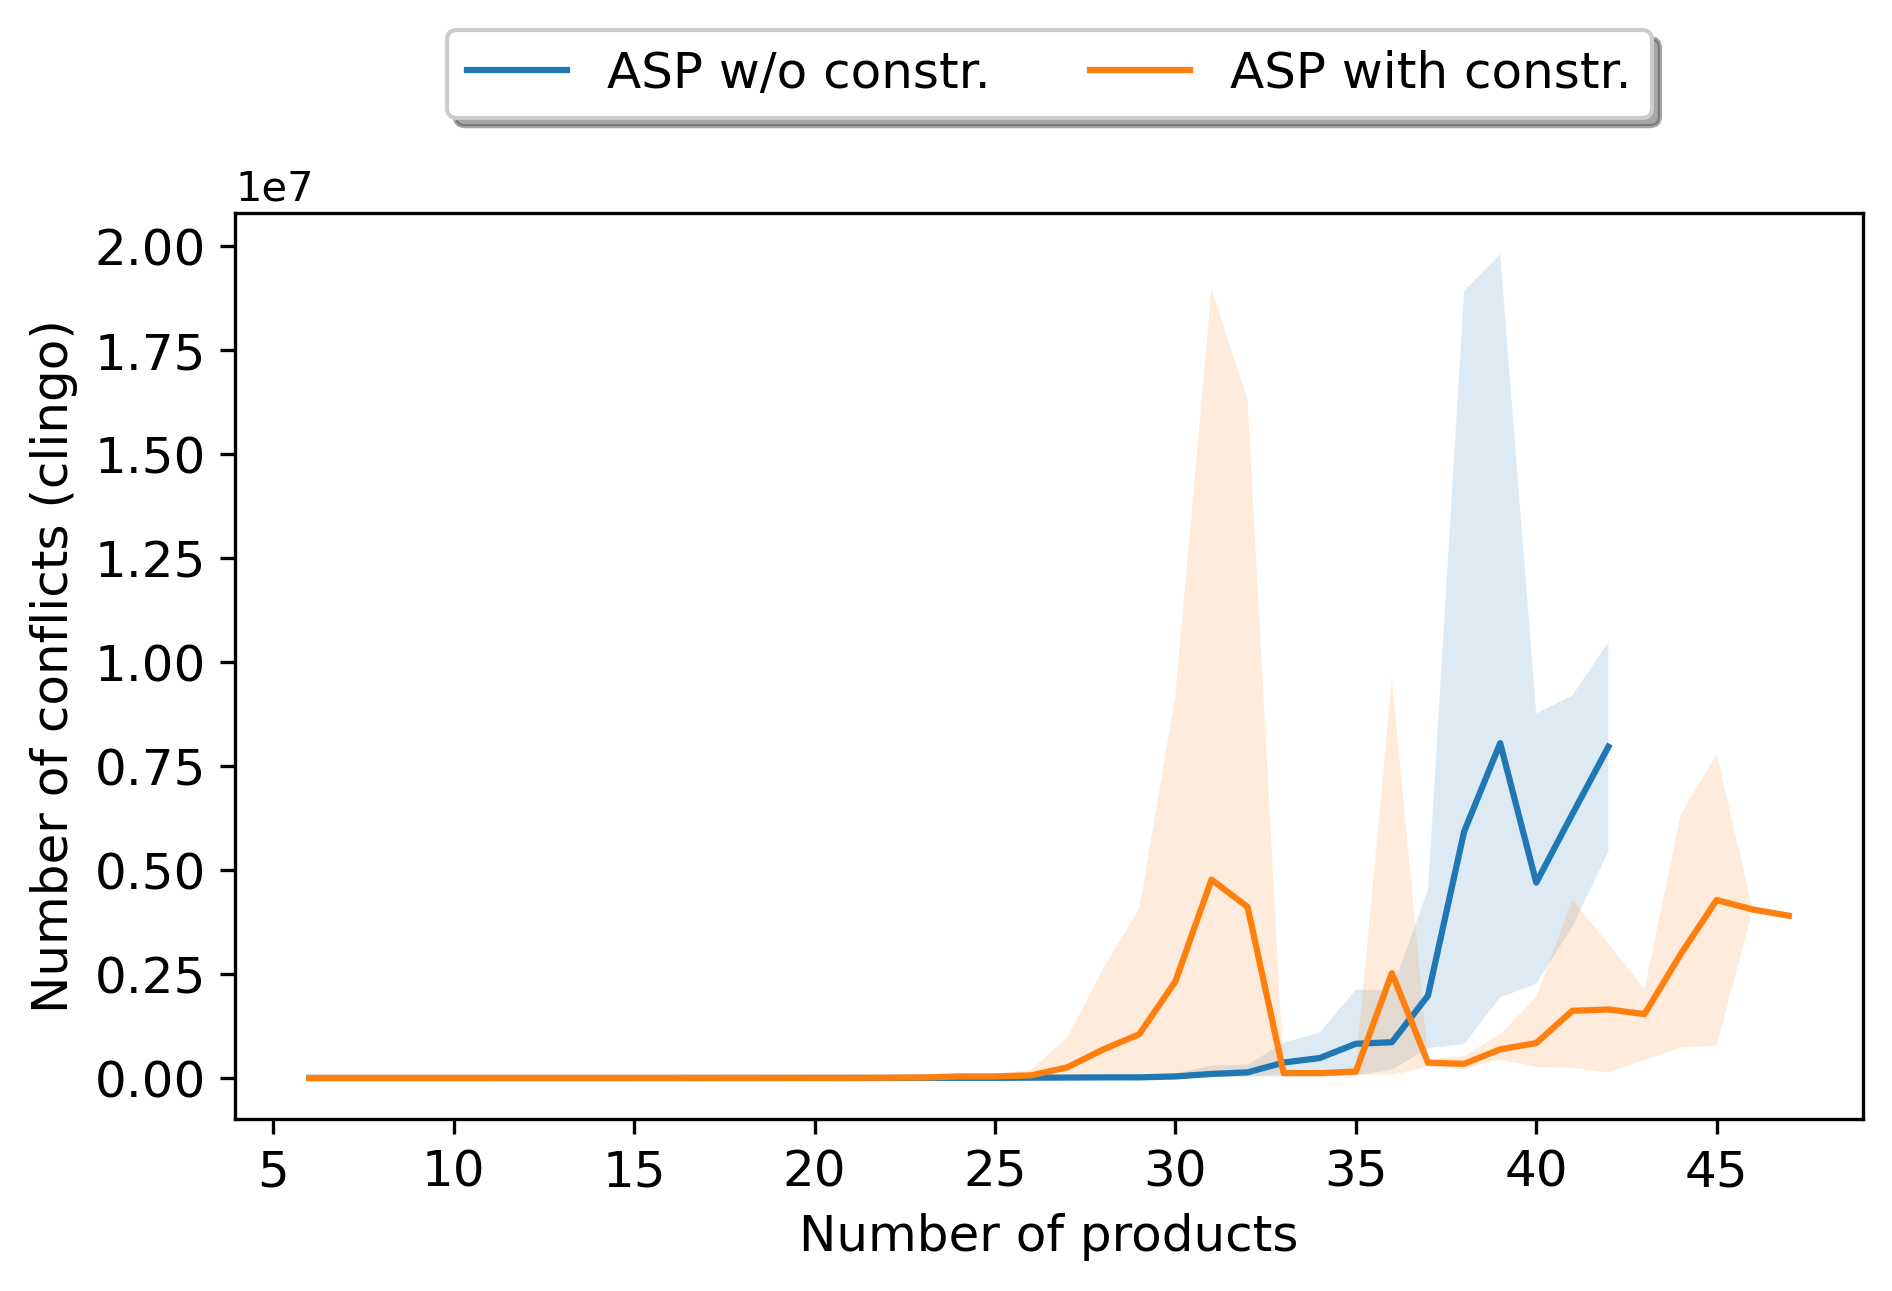

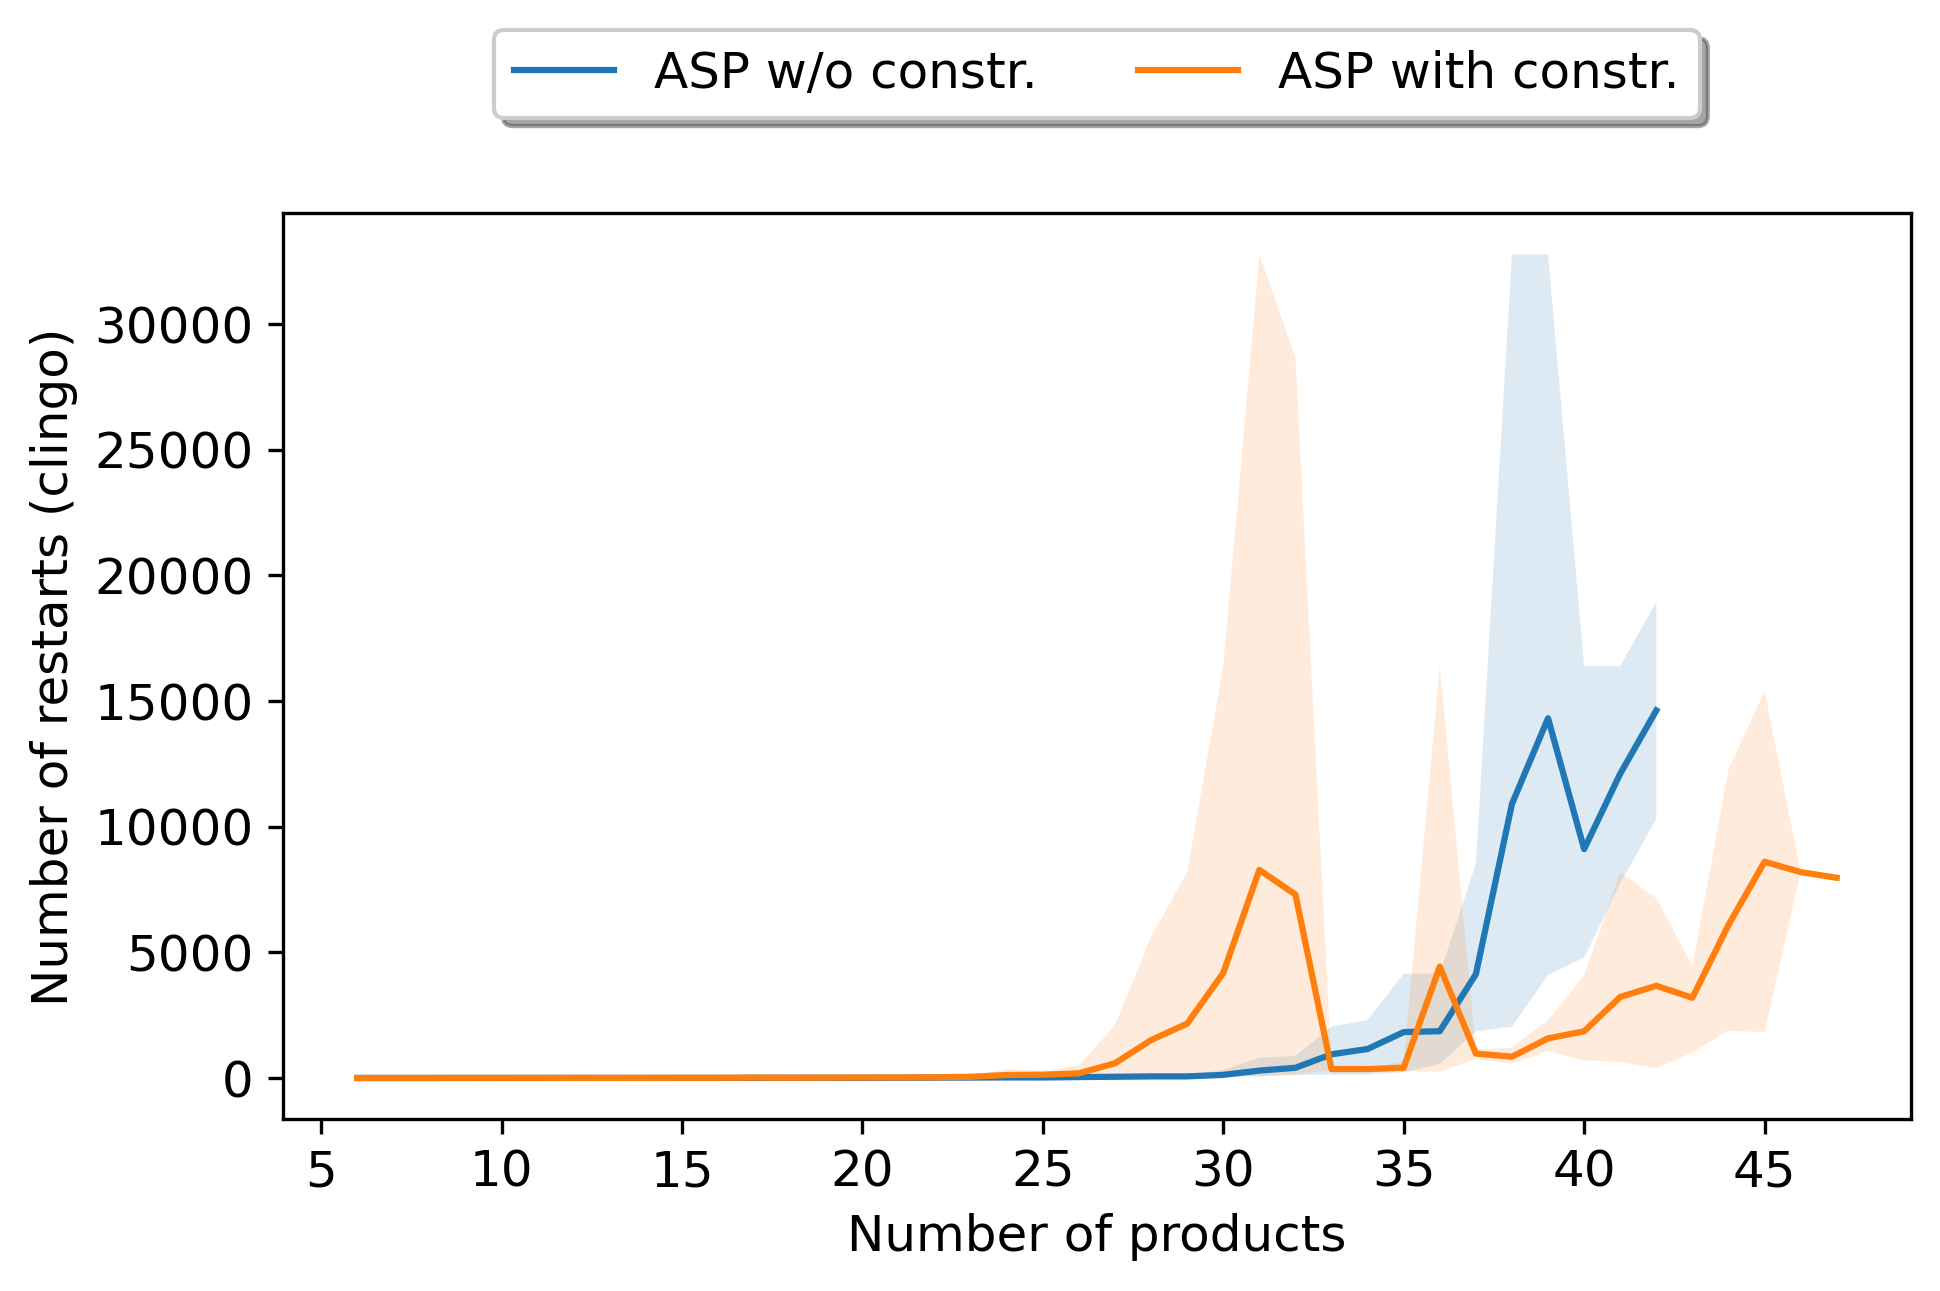

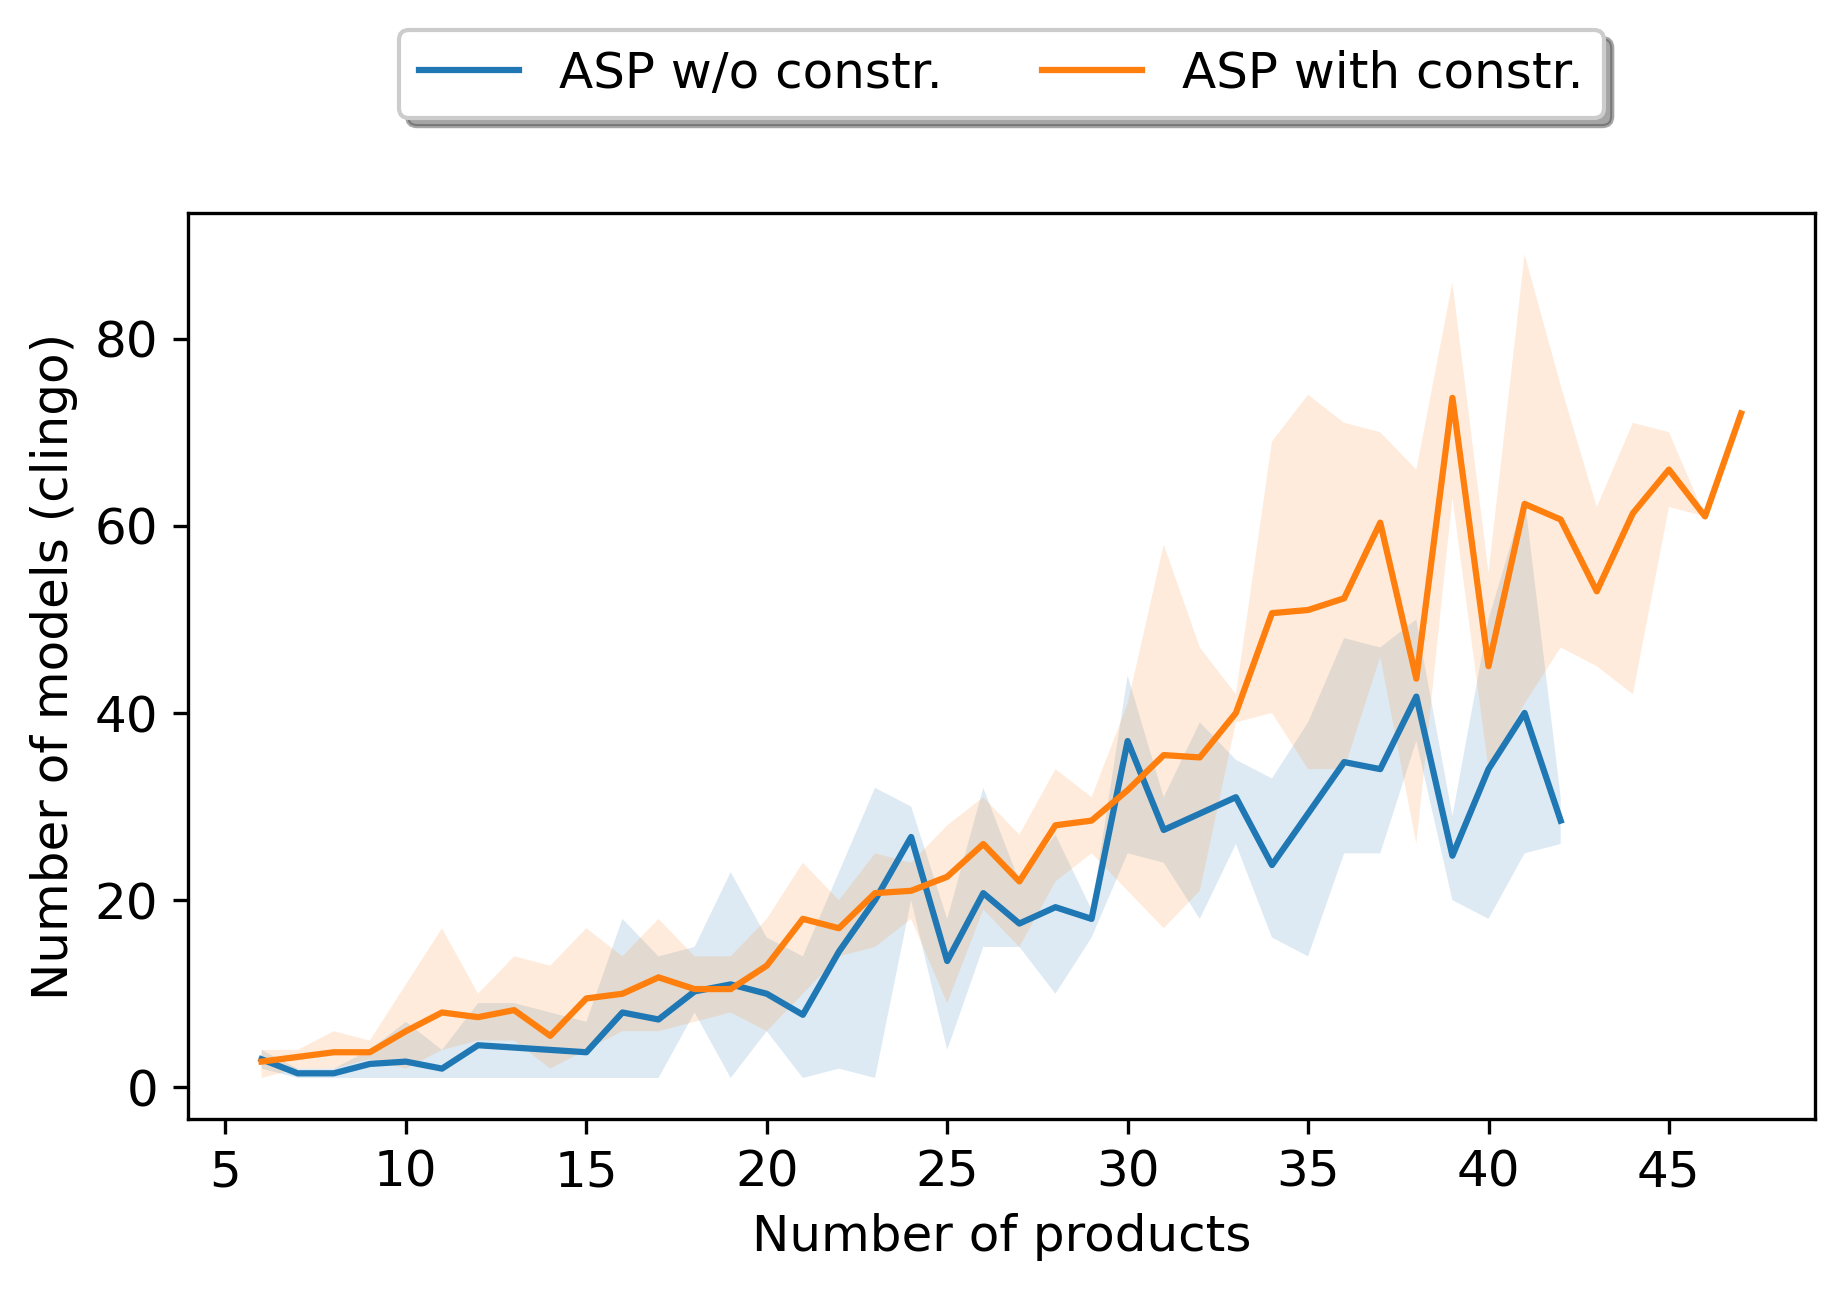

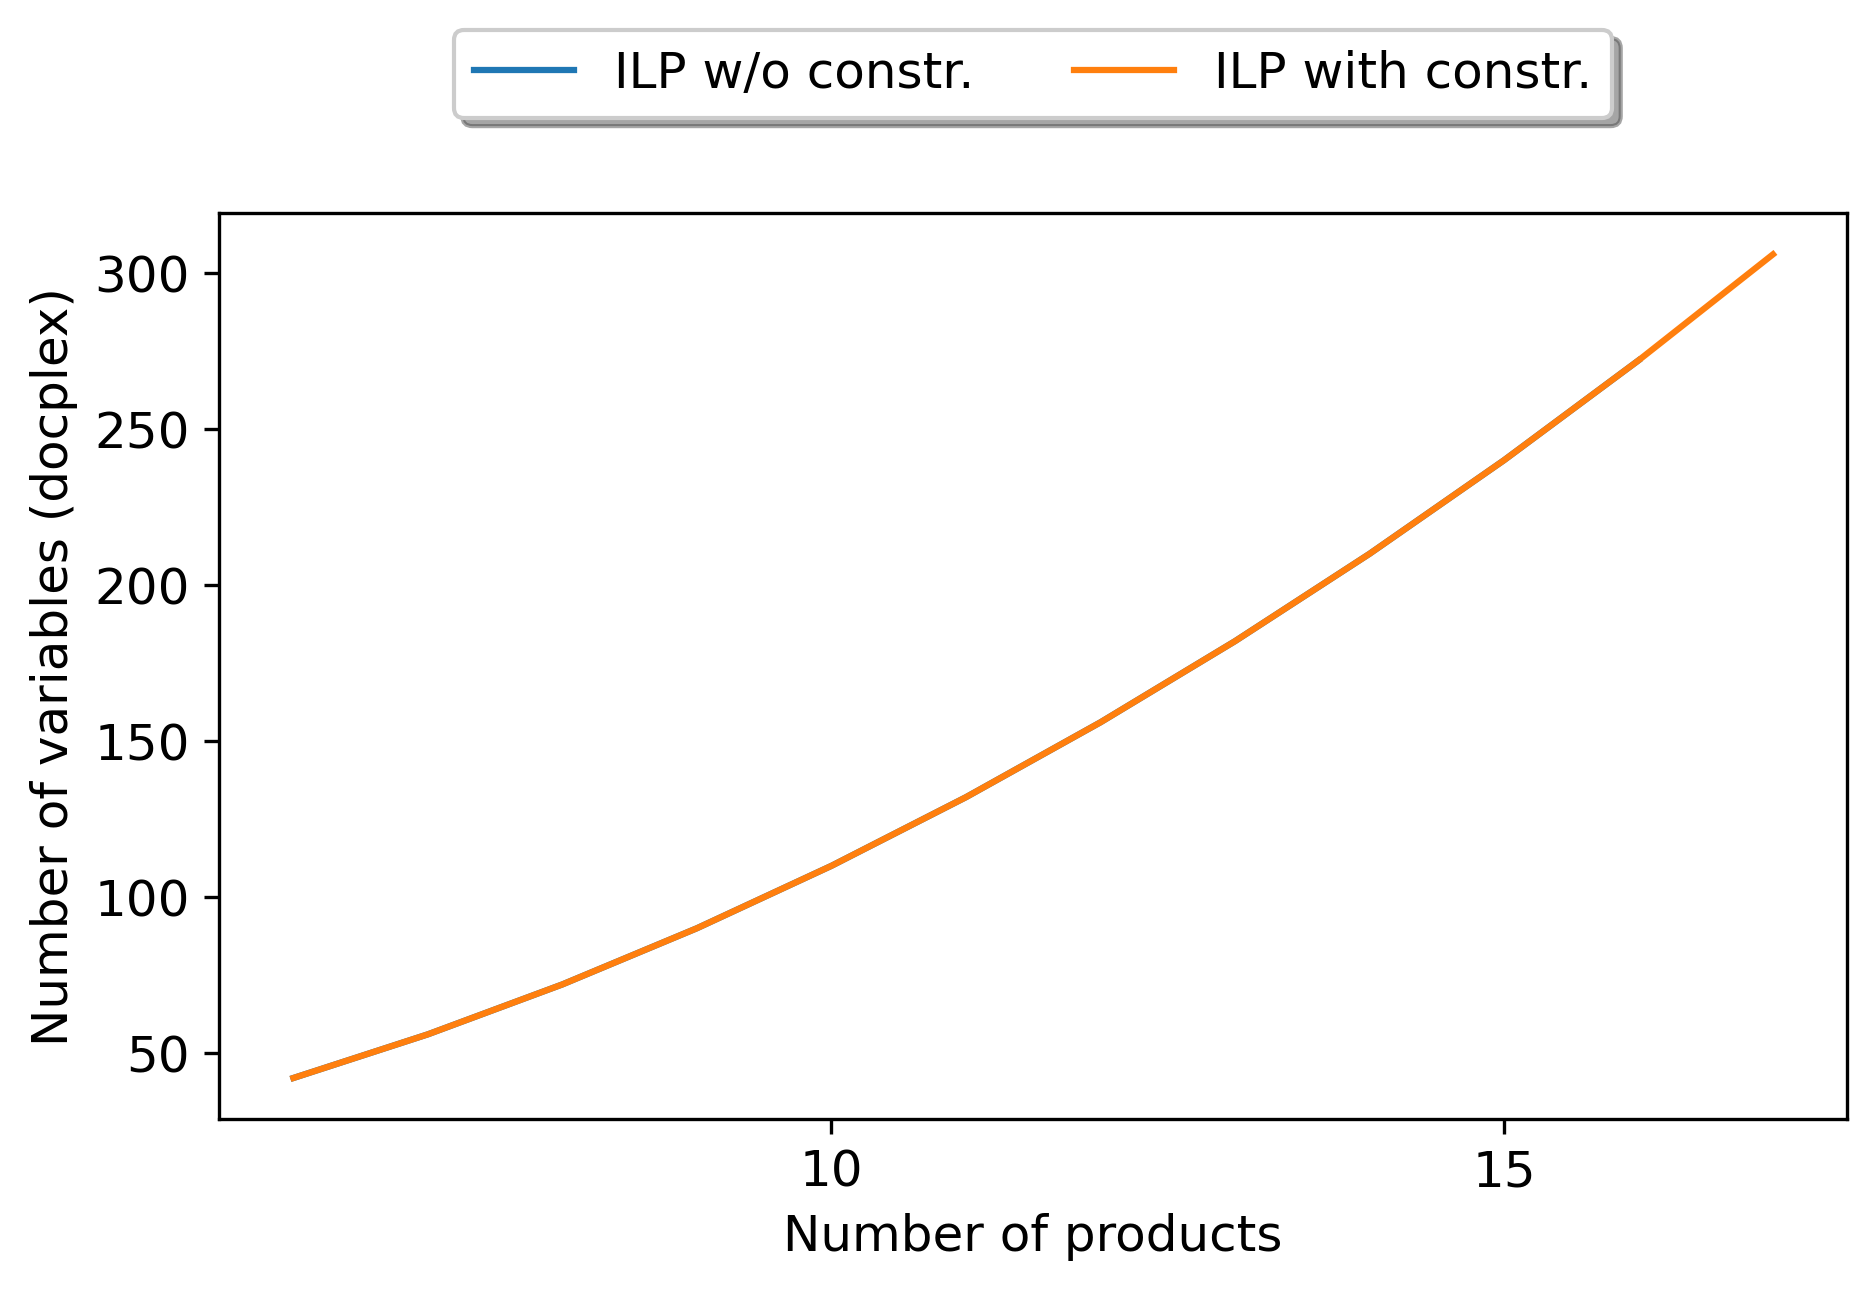

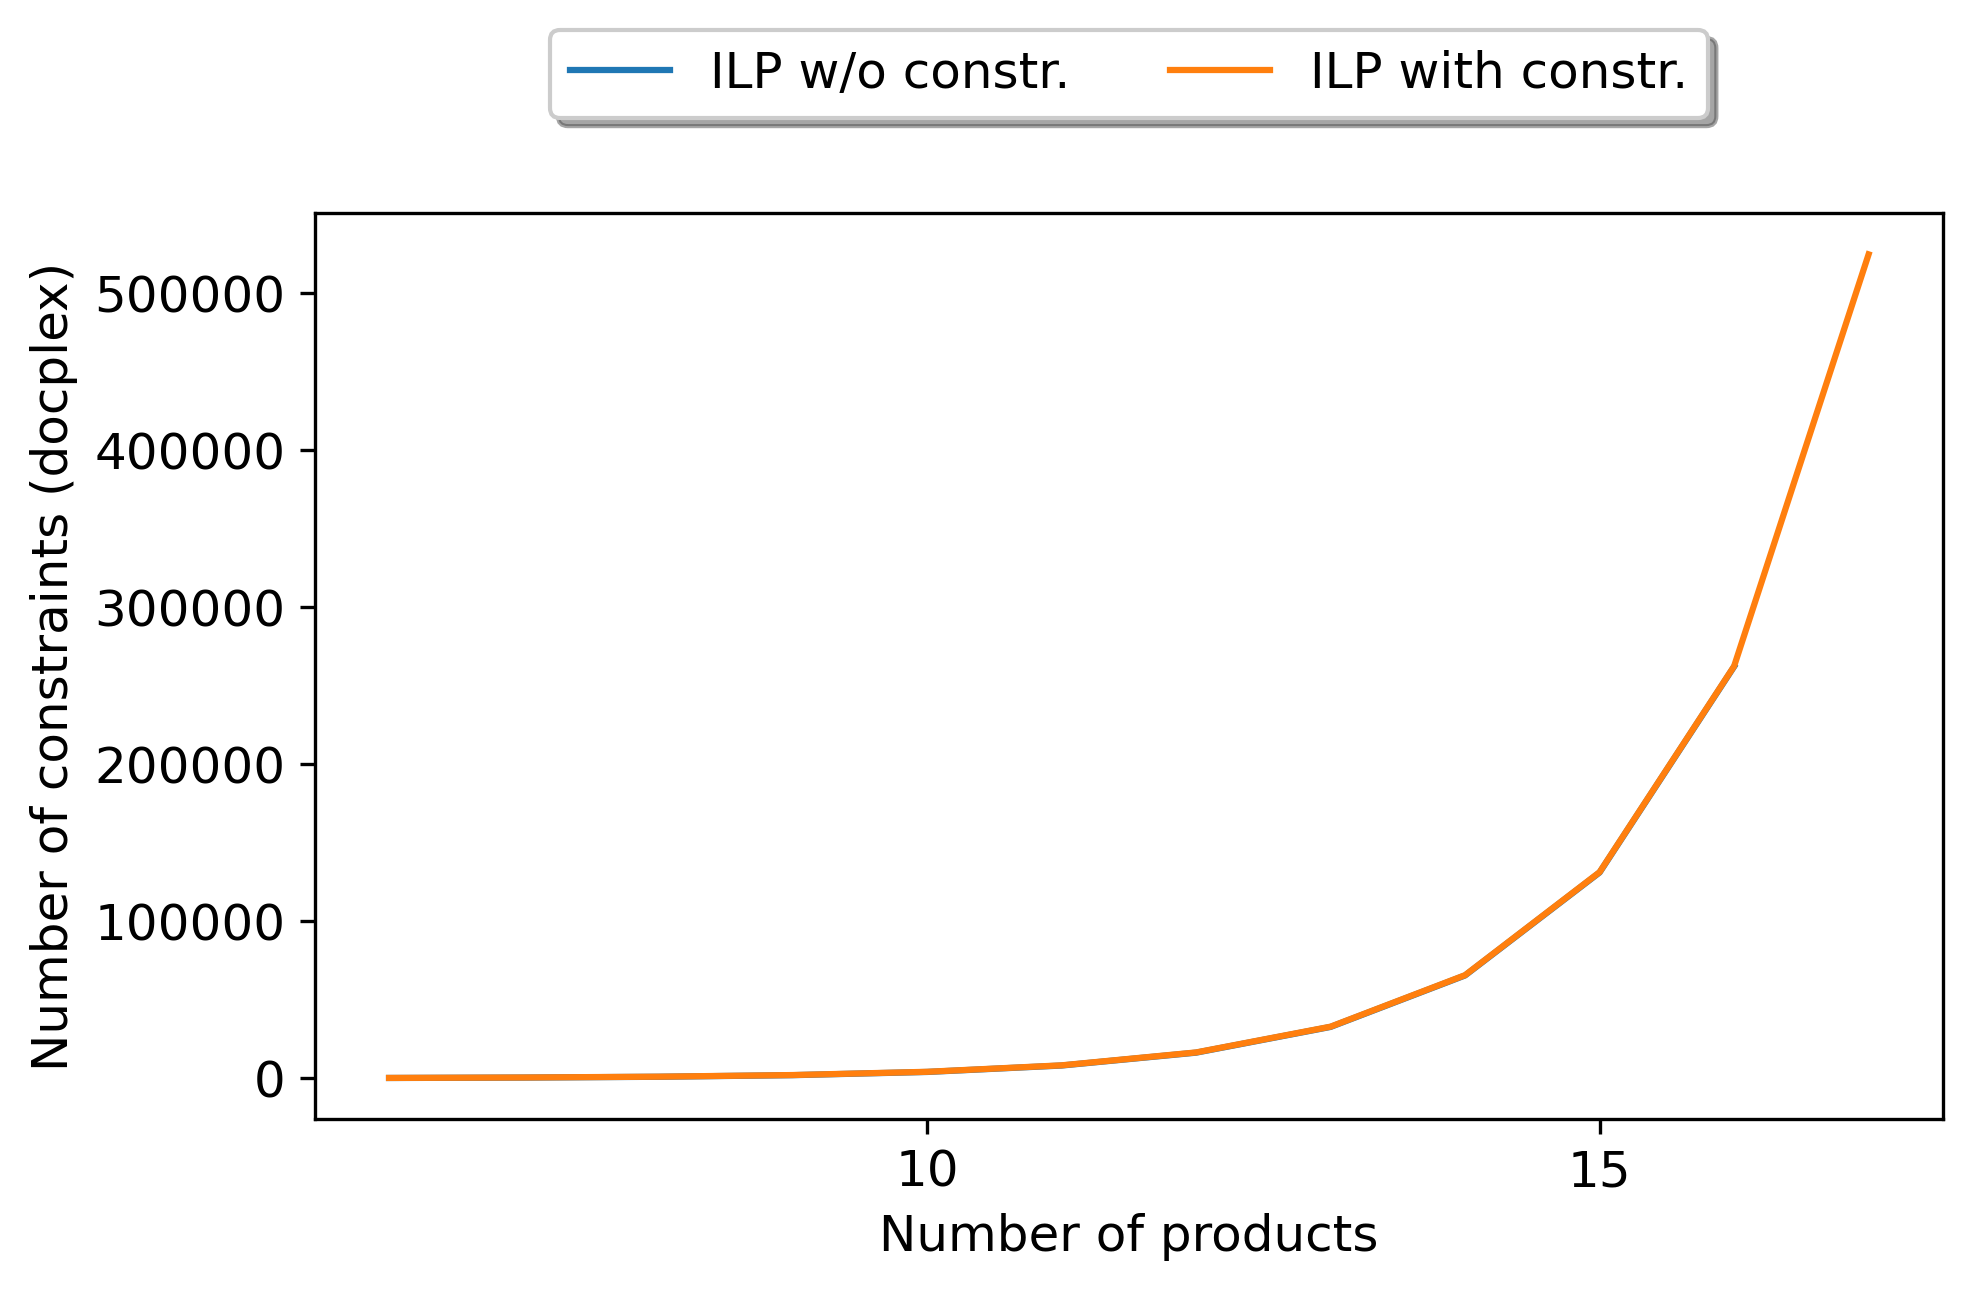

In [17]:
for metric, ylabel in metrics.items():
    plt.figure(figsize=(7, 4))
    # plt.title(f'Computational experiment (Metric {metric})', fontsize=12)
    plt.xticks(range(5, max(numProducts) + 1, 5), fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Number of products', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)

    for approach in approaches:
        if approach == 'lp_normal':
            continue

        for consider_constraints in consider_constraints_options:
            if len(data[approach][consider_constraints][metric]['numProducts']) > 0:
                plt.plot(
                    data[approach][consider_constraints][metric]['numProducts'],
                    data[approach][consider_constraints][metric]['means'],
                    # label=f'{approach}_{consider_constraints}')
                    # label=labels[consider_constraints])
                    label=labels[approach][consider_constraints])
                plt.fill_between(
                    data[approach][consider_constraints][metric]['numProducts'],
                    data[approach][consider_constraints][metric]['lbs'],
                    data[approach][consider_constraints][metric]['ubs'],
                    alpha=0.15)

    plt.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.23), ncol=3, fancybox=True, shadow=True)
    plt.show()